In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

%matplotlib inline

In [3]:
data = pd.read_csv('data_format2/train_format2.csv')
test = pd.read_csv('data_format2/test_format2.csv')

In [4]:
data.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [5]:
def split_data(data):
    user_habit = data[data['label'] == -1]
    real_data = data[data['label'] != -1]
    return real_data, user_habit

In [6]:
# 分割新购买数据和非新购买数据
train_data, train_user_habit = split_data(data)

In [7]:
print('length of train data:', len(train_data))
train_data.info()

length of train data: 260864
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260864 entries, 6 to 7030721
Data columns (total 6 columns):
user_id         260864 non-null int64
age_range       259611 non-null float64
gender          257153 non-null float64
merchant_id     260864 non-null int64
label           260864 non-null int64
activity_log    260811 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 13.9+ MB


In [8]:
print('length of train user habit:', len(train_user_habit))
train_user_habit.info(null_counts=True)

length of train user habit: 6769859
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6769859 entries, 0 to 7030722
Data columns (total 6 columns):
user_id         6769859 non-null int64
age_range       6751732 non-null float64
gender          6711858 non-null float64
merchant_id     6769859 non-null int64
label           6769859 non-null int64
activity_log    6766937 non-null object
dtypes: float64(2), int64(3), object(1)
memory usage: 361.5+ MB


年龄、性别、行为记录有空值。对于新购买的店铺，至少应该有一条购买的行为记录，所以没有任何记录的情况应该是由于数据错误。而年龄和性别先统一用数字表示空值。购买过的店铺中也包含空的行为记录。

In [9]:
new_train = train_data.copy()

In [10]:
def fill_na_age_and_gender(data):
    values = {'gender': 2, 'age_range': 0}
    return data.fillna(value=values)

In [11]:
new_train = fill_na_age_and_gender(new_train)
train_user_habit = fill_na_age_and_gender(train_user_habit)

## 相关属性分析

### 与性别和年龄的关系

性别和年龄缺失的情况都不算少数，这里不做补全，也不去除，以免造成更大的误差。

In [12]:
age_data = pd.crosstab(new_train['age_range'], new_train['label'], margins=True)
age_data['repeat_percent'] = age_data[1] / age_data['All']
age_data

label,0,1,All,repeat_percent
age_range,,,,
0.0,53740,3322,57062,0.058217
1.0,13,0,13,0.000000
2.0,29495,1531,31026,0.049346
3.0,65289,4080,69369,0.058816
4.0,47791,3444,51235,0.067220
5.0,23825,1793,25618,0.069990
6.0,20218,1483,21701,0.068338
7.0,3871,249,4120,0.060437
8.0,670,50,720,0.069444


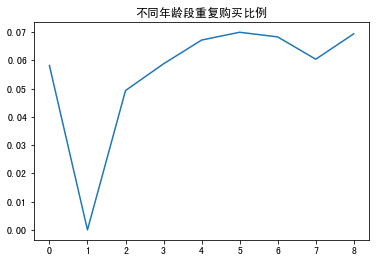

In [13]:
plt.plot(age_data.iloc[0:9, 3])
plt.title('不同年龄段重复购买比例')
plt.show()

0代表未知年龄，这部分的重复购买的概率差不多在平均水平，也算是一种公平的估计。

In [14]:
gender_data = pd.crosstab(new_train['gender'], new_train['label'], margins=True)
gender_data['repeat_percent'] = gender_data[1] / gender_data['All']
gender_data

label,0,1,All,repeat_percent
gender,,,,
0.0,165027,11387,176414,0.064547
1.0,69787,3969,73756,0.053813
2.0,10098,596,10694,0.055732
All,244912,15952,260864,0.061151


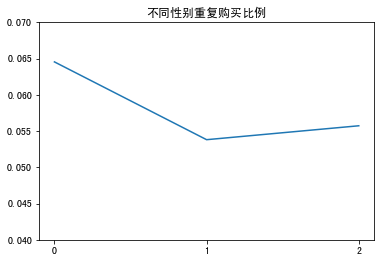

In [15]:
plt.plot(gender_data.iloc[0:3, 3])
plt.ylim((0.04,0.07))
plt.title('不同性别重复购买比例')
plt.xticks([0, 1, 2])
plt.show()

0代表未知性别，这部分的重复购买的概率差不多在平均水平，也算是一种公平的估计。

### 自定义属性添加：用户常购买的店铺数和店铺的回头客数

In [16]:
def user_repeat_sellers(data, habit_data):
    buyer_repeat_sellers = habit_data[['user_id','label']].groupby('user_id', as_index=False).count()
    buyer_repeat_sellers.columns = ['user_id', 'buyer_repeat_sellers']
    ret = data.merge(buyer_repeat_sellers, on='user_id', how='left')
    ret['buyer_repeat_sellers'] = ret['buyer_repeat_sellers'].fillna(0)
    return ret
    
def seller_repeat_users(data, habit_data):
    # 卖家的老顾客数目
    seller_repeat_buyers = habit_data[['merchant_id','label']].groupby('merchant_id', as_index=False).count()
    seller_repeat_buyers.columns = ['merchant_id', 'seller_repeat_buyers']
    ret = data.merge(seller_repeat_buyers, on='merchant_id', how='left')
    ret['seller_repeat_buyers'] = ret['seller_repeat_buyers'].fillna(0)
    return ret

In [17]:
# 不可重复执行
new_train = user_repeat_sellers(new_train, train_user_habit)
new_train = seller_repeat_users(new_train, train_user_habit)


In [18]:
new_train.head()

,user_id,age_range,gender,merchant_id,label,activity_log,buyer_repeat_sellers,seller_repeat_buyers
0,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,105.0,2861
1,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,105.0,4530
2,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,105.0,1088
3,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,105.0,7268
4,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,19.0,3102


In [19]:
bins_data = pd.qcut(new_train['buyer_repeat_sellers'], 50, labels=False, duplicates='drop')
repeat_sellers_data = pd.crosstab(bins_data, new_train['label'], margins=True)
repeat_sellers_data['repeat_percent'] = repeat_sellers_data[1] / repeat_sellers_data['All']
repeat_sellers_data

label,0,1,All,repeat_percent
buyer_repeat_sellers,,,,
0,6348,420,6768,0.062057
1,4370,265,4635,0.057174
2,5217,307,5524,0.055576
3,5943,346,6289,0.055017
4,6511,337,6848,0.049211
5,6806,419,7225,0.057993
6,6920,397,7317,0.054257
7,6908,457,7365,0.062050
8,6762,419,7181,0.058348


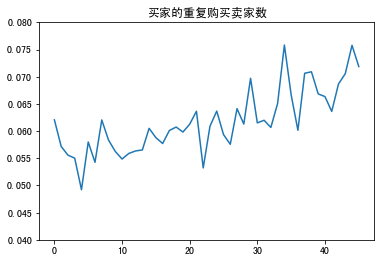

In [20]:
plt.plot(repeat_sellers_data.iloc[0:-1, 3])
plt.ylim((0.04,0.08))
plt.title('买家的重复购买卖家数')
plt.show()

In [21]:
bins_data = pd.qcut(new_train['seller_repeat_buyers'], 50, labels=False, duplicates='drop')
repeat_buyers_data = pd.crosstab(bins_data, new_train['label'], margins=True)
repeat_buyers_data['repeat_percent'] = repeat_buyers_data[1] / repeat_buyers_data['All']
repeat_buyers_data

label,0,1,All,repeat_percent
seller_repeat_buyers,,,,
0,4932,304,5236,0.058060
1,4949,299,5248,0.056974
2,4935,271,5206,0.052055
3,4915,271,5186,0.052256
4,5052,345,5397,0.063924
5,4857,234,5091,0.045963
6,4922,290,5212,0.055641
7,4978,228,5206,0.043796
8,4904,271,5175,0.052367


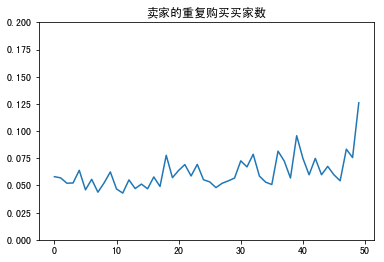

In [22]:
plt.plot(repeat_buyers_data.iloc[0:-1, 3])
plt.ylim((0,0.2))
plt.title('卖家的重复购买买家数')
plt.show()

In [23]:
new_train.head()

,user_id,age_range,gender,merchant_id,label,activity_log,buyer_repeat_sellers,seller_repeat_buyers
0,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,105.0,2861
1,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,105.0,4530
2,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,105.0,1088
3,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,105.0,7268
4,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,19.0,3102


### 自定义属性添加：买家购买、点击、喜欢、加购物车的次数

In [24]:
def log_times(logs, log_types=[0, 2, 3]):
    ret = []
    if logs:
        logs = str(logs) + '#'
        for log_type in log_types:
            ss = str(log_type) + '#'
            count = logs.count(ss)
            out_count = 1 if count == 0 and log_type == 2 else count
            ret.append(out_count)
    else:
        ret = [0, 1, 0]
    return ret

In [25]:
def get_action_times(data):
    actions = data['activity_log'].apply(log_times)
    data['click_times'], data['buy_times'], data['like_times'] = zip(*actions)


In [26]:
get_action_times(new_train)
new_train.head()

,user_id,age_range,gender,merchant_id,label,activity_log,buyer_repeat_sellers,seller_repeat_buyers,click_times,buy_times,like_times
0,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,105.0,2861,36,1,2
1,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,105.0,4530,13,1,0
2,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,105.0,1088,12,6,0
3,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,105.0,7268,1,1,0
4,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,19.0,3102,7,1,0


### 自定义属性添加：用户第一次行为记录离双十一月数、操作过的商品数、之前购买同类商品数、近半年购买商品总数

In [27]:
def get_group_habit(habit_data):
    habit_group = habit_data[['user_id', 'activity_log']].groupby('user_id')
    return habit_group

In [28]:
def log_first_time(logs):
    pattern = re.compile(r'(\d{1,7}):(\d{1,4}):(\d{1,4}):(\d{4}):([0-3]{1})#?')
    match = pattern.findall(str(logs))
    item_num, earliest_action, cats = 0, 0, []
    if match:
        match = np.array(match)
        item_num = len(np.unique(match[:, 0]))
        cats = np.unique(match[match[:, 4] == '2'][:, 1])
        earliest_action = 11 - (int(np.sort(np.unique(match[:, 3]))[0]) // 100)
    return item_num, earliest_action, cats

In [29]:
def bought_times(item, group_habit_data):
    right_cats = 0
    total_nums = 0
    if item['user_id'] in group_habit_data.groups:
        habit = group_habit_data.get_group(item['user_id'])['activity_log']
        habit = habit.apply(str)
        all_activities = '#'.join(habit)
        cats = item['1111_cats']
        pattern = re.compile(r'(\d{1,7}):(\d{1,4}):(\d{1,4}):(\d{4}):([0-3]{1})#?')
        match = pattern.findall(str(all_activities))
        if match:
            match = np.array(match)
            match_cats = match[match[:, 4] == '2'][:, 1]
            total_nums = len(match_cats)
            right_cats = sum([c in cats for c in match_cats])
    return total_nums, right_cats

In [30]:
def get_others(data, habit_data):
    group_habit_data = get_group_habit(habit_data)
    log_analysis = data['activity_log'].apply(log_first_time)
    data['action_item_nums'], data['earliest_action'], bought_cats = zip(*log_analysis)
    
    data.loc[:, '1111_cats'] = bought_cats
    bought_analysis = data[['user_id', '1111_cats']].apply(bought_times, group_habit_data=group_habit_data, axis=1)
    data['bought_nums'], data['bought_same_cat_nums'] = zip(*bought_analysis)
    del data['1111_cats']


In [31]:
get_others(new_train, train_user_habit)
new_train.head()

,user_id,age_range,gender,merchant_id,label,activity_log,buyer_repeat_sellers,seller_repeat_buyers,click_times,buy_times,like_times,action_item_nums,earliest_action,bought_nums,bought_same_cat_nums
0,34176,6.0,0.0,3906,0,757713:821:6268:1110:0#757713:821:6268:1110:0#...,105.0,2861,36,1,2,20,1,25,0
1,34176,6.0,0.0,121,0,800752:1028:2337:1110:0#800752:1028:2337:1110:...,105.0,4530,13,1,0,1,0,25,0
2,34176,6.0,0.0,4356,1,709909:1208:2276:1110:0#709909:1208:2276:1110:...,105.0,1088,12,6,0,2,0,25,1
3,34176,6.0,0.0,2217,0,399879:656:3012:1111:2#399879:656:3012:1111:0,105.0,7268,1,1,0,1,0,25,0
4,230784,0.0,0.0,4818,0,155695:2:7606:1111:2#155695:2:7606:1111:0#1556...,19.0,3102,7,1,0,1,0,6,0


### 数据准备

In [32]:
default_features = ['buy_times', 'earliest_action', 'buyer_repeat_sellers', 'seller_repeat_buyers', 'click_times', 'like_times', 'action_item_nums', 'bought_nums', 'bought_same_cat_nums']

def prepare_features(data, features=default_features, operation='none'):
    fix_features = ['age_range', 'gender']
    if operation == 'scaler':
        to_scale_features = []
        for f in features:
            if data[f].max() > 10:
                to_scale_features.append(f)
            else:
                fix_features.append(f)
        to_prepare = data[to_scale_features]
        scaler = StandardScaler()
        prepared = scaler.fit_transform(to_prepare)
    elif operation == 'categorize':
        prepared = np.array([])
        for f in features:
            indexes = pd.qcut(data[f], 50, labels=False, duplicates='drop')
            if not prepared.any():
                prepared = np.append(prepared, indexes)
            else:
                prepared = np.vstack((prepared, [indexes]))

        prepared = prepared.T
    else:
        prepared = data[features]
    prepared = np.hstack((data[fix_features].values, prepared))
    return prepared


In [33]:
def prepare_data(data, habit_data):
    data = fill_na_age_and_gender(data)
    habit_data = fill_na_age_and_gender(habit_data)
    
    data = user_repeat_sellers(data, habit_data)
    data = seller_repeat_users(data, habit_data)
    
    get_action_times(data)
    get_others(data, habit_data)
    features = prepare_features(data, operation='categorize')
    return features

### 预测

In [34]:
prepared_data = prepare_features(new_train, operation='categorize')
gb_clf = GaussianNB()
gb_scores = cross_val_score(gb_clf, prepared_data, new_train['label'], scoring='f1', cv=5)
print('gb_scores:', gb_scores)
print('mean_score:', np.mean(gb_scores))

gb_scores: [ 0.16278027  0.15705856  0.15101289  0.15329848  0.1466289 ]
mean_score: 0.154155817603


比随机森林高很多了。

In [35]:
clf = GaussianNB()
clf.fit(prepared_data, new_train['label'])

GaussianNB(priors=None)

In [36]:
prepared_data[:,2]

array([ 0.,  0.,  3., ...,  0.,  0.,  0.])

## 测试

In [37]:
test_data, test_habit_data = split_data(test)
features = prepare_data(test_data, test_habit_data)


In [38]:
prob = clf.predict_proba(features)
submission = pd.DataFrame(test_data[['user_id', 'merchant_id']])
submission['prob'] = prob[:, 1]
submission.to_csv('prediction.csv', index=False)